This is a notebook for exploring quantify dependence. To be more specific, we test some distance metrics on a single and relatively simpler model. Here the selected test models is Beer_MolBiosyst2014, which is the third model in collection 2. This model has 4 states and two of them are observanle. 19 conditions were provided and we use time series data generated under condition 1.  
To achieve this, we mainly have three steps which are given below:  
1. Load the genereated time series data.
2. Designate a poly_degree first then vary its values. Rule for designating poly_degree may depend on exact representations of a model.  
3. Quantify the dependence of these basis functions through some distance metrcis. Note that this metric should follow triangle inequality. Then plotting the heat map or other ways to visualize the relationship between these basis functions.  
4. Cluster these basis functions into some groups according to the distance metric used.  
5. Compare terms within these groups with terms in the original model and find if some terms cannot be distinguished. For example, a group contains x, x^2 and xy, and x is one of the terms in the original model, then we can conclude that x^2 and xy may not be distinguished.


In [1]:
import pandas as pd
import itertools
from dae_finder import PolyFeatureMatrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import seaborn as sns
import math

import Functions
import Definitions
import Jensen_Shannon as JS

In [2]:
# Load time series data
data = pd.read_excel('Beer_exp.xlsx')
data.rename(columns={
    'x_Exp_1': 'x1',
    'x_Exp_2': 'x2',
    'x_Exp_3': 'x3',
    'x_Exp_4': 'x4'
},inplace=True)
data_states = data.copy().drop(columns={'t_Exp'})

In [3]:
print(data.head())

   t_Exp        x1         x2        x3            x4
0    0.0  0.014701  10.000000  0.000000  0.000000e+00
1    5.0  0.014701   9.995934  0.004066  1.865008e-09
2   10.0  0.014701   9.991869  0.008131  1.472746e-08
3   15.0  0.014701   9.987806  0.012194  4.906997e-08
4   20.0  0.014701   9.983745  0.016255  1.148330e-07


In [4]:
# Create function library and generate corresponding values
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_states)


# Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,x1,x2,x3,x4,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,0.014701,10.000000,0.000000,0.000000e+00,0.000216,0.147012,0.000000,0.000000e+00,100.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,0.014701,9.995934,0.004066,1.865008e-09,0.000216,0.146952,0.000060,2.741790e-11,99.918691,0.040646,1.864250e-08,0.000017,7.583635e-12,3.478255e-18
2,0.014701,9.991869,0.008131,1.472746e-08,0.000216,0.146893,0.000120,2.165116e-10,99.837448,0.081243,1.471548e-07,0.000066,1.197472e-10,2.168980e-16
3,0.014701,9.987806,0.012194,4.906997e-08,0.000216,0.146833,0.000179,7.213886e-10,99.756271,0.121789,4.901014e-07,0.000149,5.983503e-10,2.407862e-15
4,0.014701,9.983745,0.016255,1.148330e-07,0.000216,0.146773,0.000239,1.688186e-09,99.675160,0.162286,1.146464e-06,0.000264,1.866618e-09,1.318662e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.624678,0.013576,4.944838,1.742630e-01,0.390223,0.008481,3.088934,1.088584e-01,0.000184,0.067133,2.365854e-03,24.451423,8.617025e-01,3.036761e-02
711,0.624679,0.013344,4.936703,1.736766e-01,0.390223,0.008336,3.083853,1.084921e-01,0.000178,0.065874,2.317494e-03,24.371041,8.573900e-01,3.016357e-02
712,0.624679,0.013115,4.928592,1.730928e-01,0.390223,0.008193,3.078786,1.081274e-01,0.000172,0.064639,2.270131e-03,24.291022,8.531039e-01,2.996112e-02
713,0.624679,0.012890,4.920505,1.725116e-01,0.390223,0.008052,3.073734,1.077643e-01,0.000166,0.063427,2.223744e-03,24.211367,8.488442e-01,2.976026e-02


In [6]:
std = Definitions.DataStandard(candidate_lib_full)
print(std['x1'])

0     -1.150318
1     -1.150318
2     -1.150318
3     -1.150318
4     -1.150318
         ...   
710    1.021863
711    1.021864
712    1.021864
713    1.021864
714    1.021864
Name: x1, Length: 715, dtype: float64


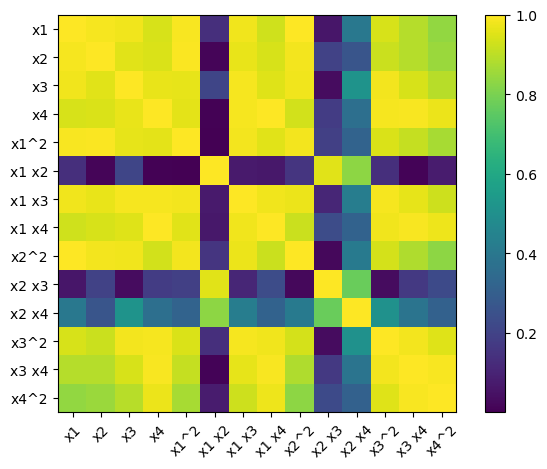

In [5]:
# Quantify dependence based on correlations
# Here we use Pearson first and heat map
corr = candidate_lib_full.corr()
corr_abs  = abs(corr)

fig, ax = plt.subplots()
im = ax.imshow(corr_abs, aspect='equal')
ax.set_xticks(range(len(corr_abs.columns)))
ax.set_yticks(range(len(corr_abs.columns)))
ax.set_xticklabels(corr_abs.columns, rotation=45)
ax.set_yticklabels(corr_abs.columns)
fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [5]:
Distribution,grid = JS.KDE_distribution(candidate_lib_full,'False','False',grid_points=1000)
Distance = JS.distance_JS(Distribution,grid)
#weights = JS.weight_calculation(Distribution,grid)
#Distance = JS.distance_JS_test(Distribution,weights)
PJSD = JS.PJSD(candidate_lib_full,std_index=True,dx=3,taux=1)

In [6]:
# Verify triangle inequality, relative distance(optional) and upper bound
print(Definitions.verify_triangle(Distance))
print(Definitions.verify_bound(Distance,math.e))
print(Definitions.verify_relative(Distance))

True
True
False


In [7]:
print(Definitions.verify_triangle(PJSD))
print(Definitions.verify_bound(PJSD,math.e))
print(Definitions.verify_relative(PJSD))

True
True
False


In [8]:
# poly_degree = 2
print(Distance.head())

            x1        x2        x3        x4      x1^2     x1 x2     x1 x3  \
x1    0.000000  0.224101  0.216046  0.167259  0.159133  0.140925  0.194923   
x2    0.224101  0.000000  0.137907  0.238530  0.234992  0.192708  0.177330   
x3    0.216046  0.137907  0.000000  0.234552  0.230010  0.182476  0.153995   
x4    0.167259  0.238530  0.234552  0.000000  0.110153  0.143543  0.212700   
x1^2  0.159133  0.234992  0.230010  0.110153  0.000000  0.144329  0.207820   

         x1 x4      x2^2     x2 x3     x2 x4      x3^2     x3 x4      x4^2  
x1    0.171696  0.254215  0.237361  0.104034  0.249362  0.174605  0.177439  
x2    0.245785  0.198216  0.119208  0.230006  0.187824  0.181150  0.250798  
x3    0.243356  0.210307  0.130649  0.224250  0.193621  0.171753  0.249299  
x4    0.101303  0.257796  0.247541  0.105553  0.254791  0.182680  0.138946  
x1^2  0.153278  0.256915  0.245083  0.109211  0.253460  0.182641  0.154506  


In [9]:
print(PJSD.head())

            x1        x2        x3        x4      x1^2     x1 x2     x1 x3  \
x1    0.000000  0.832555  0.379784  0.359604  0.000000  0.666528  0.372816   
x2    0.832555  0.000000  0.549299  0.569036  0.832555  0.258169  0.556128   
x3    0.379784  0.549299  0.000000  0.039385  0.379784  0.343732  0.008309   
x4    0.359604  0.569036  0.039385  0.000000  0.359604  0.364819  0.034934   
x1^2  0.000000  0.832555  0.379784  0.359604  0.000000  0.666528  0.372816   

         x1 x4      x2^2     x2 x3     x2 x4      x3^2     x3 x4      x4^2  
x1    0.357827  0.832555  0.465745  0.434975  0.379784  0.365795  0.359604  
x2    0.570768  0.000000  0.464087  0.494770  0.549299  0.562995  0.569036  
x3    0.026181  0.549299  0.107076  0.072806  0.000000  0.035361  0.039385  
x4    0.031251  0.569036  0.126327  0.089773  0.039385  0.007383  0.000000  
x1^2  0.357827  0.832555  0.465745  0.434975  0.379784  0.365795  0.359604  


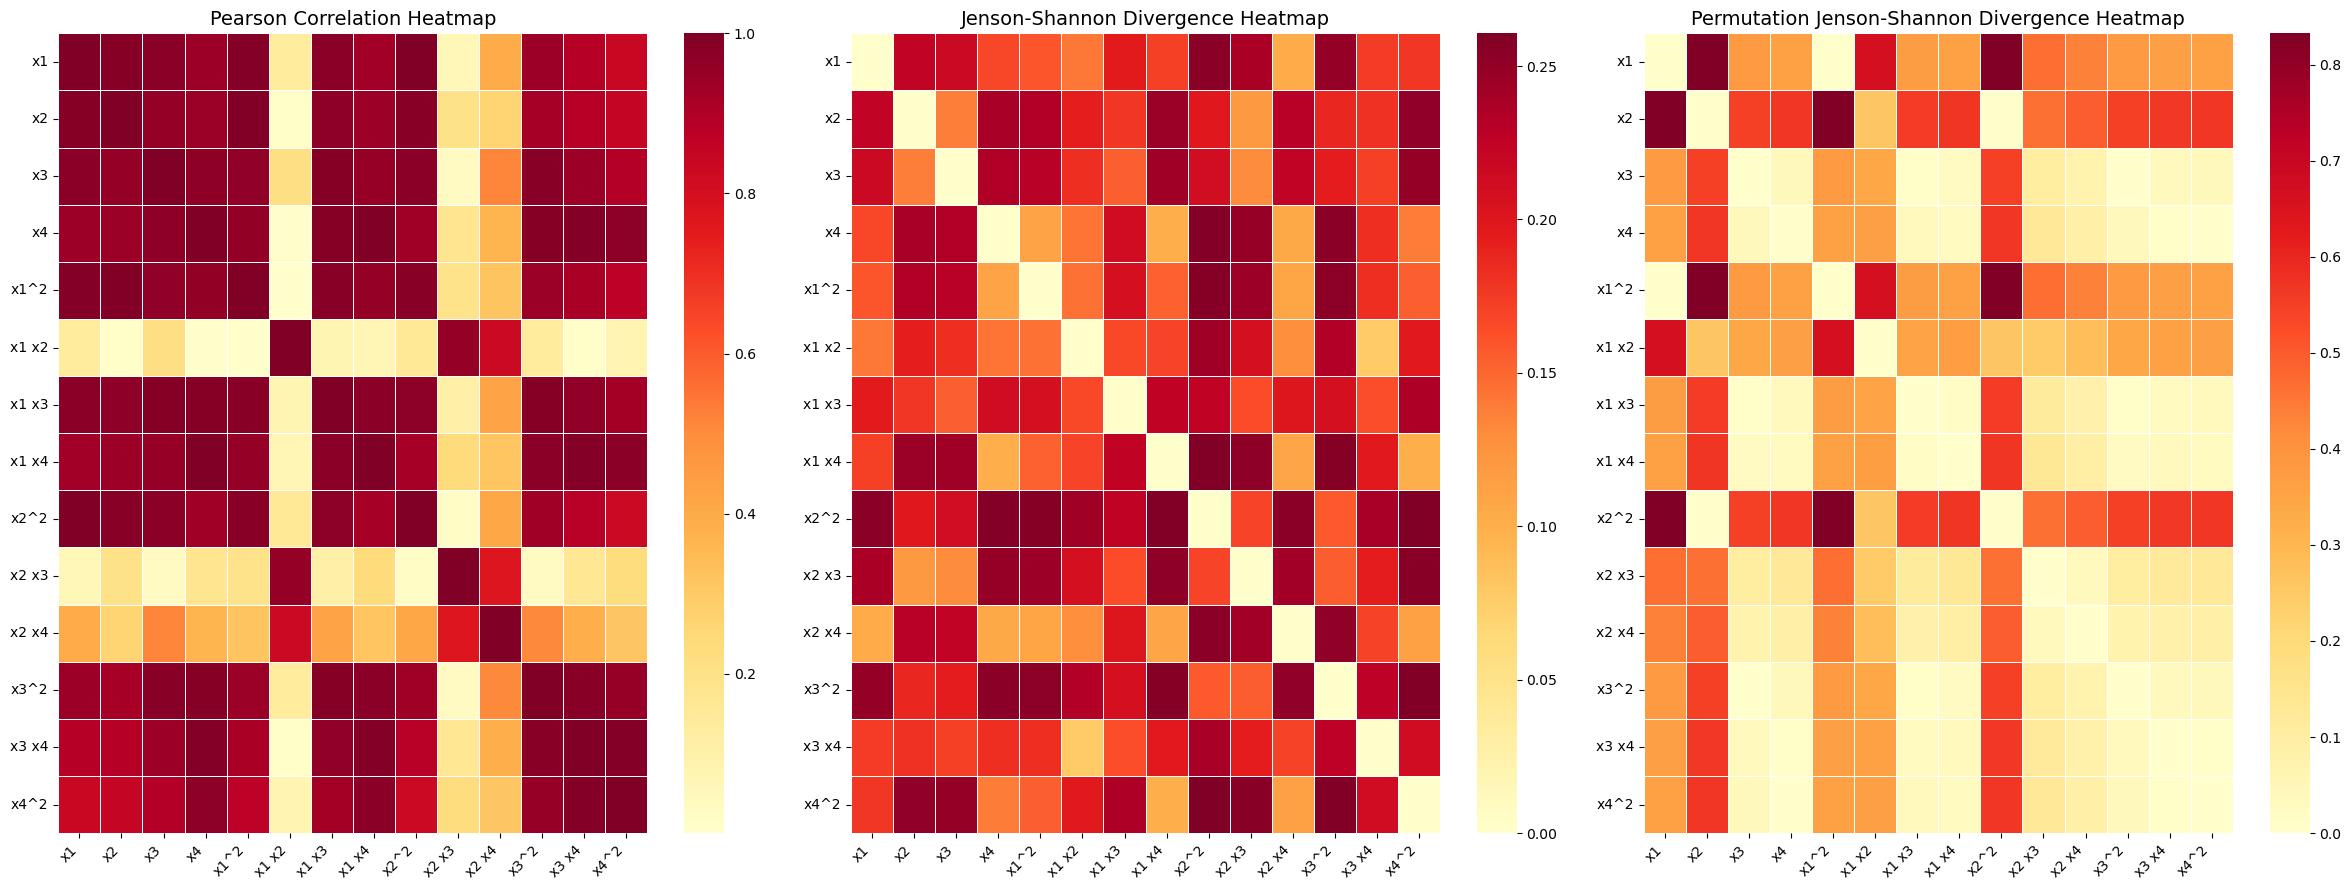

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
corr = candidate_lib_full.corr()
Functions.heatmap(abs(corr),"Pearson Correlation",ax=ax1)
Functions.heatmap(Distance,"Jenson-Shannon Divergence",ax=ax2)
Functions.heatmap(PJSD,"Permutation Jenson-Shannon Divergence",ax=ax3)

plt.tight_layout()
plt.show()

In [55]:
clusters, medoid_funcs = Functions.cluster(PJSD,k=3)
for label,funcs in clusters.items():
    print(f"Cluster {label}: {', '.join(funcs)}")

print(f"Cluster center : {medoid_funcs}")

Cluster 0: x3, x4, x1 x3, x1 x4, x2 x3, x2 x4, x3^2, x3 x4, x4^2, x1^2 x3, x1^2 x4, x1 x2 x3, x1 x2 x4, x1 x3^2, x1 x3 x4, x1 x4^2, x2^2 x3, x2^2 x4, x2 x3^2, x2 x3 x4, x2 x4^2, x3^3, x3^2 x4, x3 x4^2, x4^3
Cluster 1: x2, x1 x2, x2^2, x1^2 x2, x1 x2^2, x2^3
Cluster 2: x1, x1^2, x1^3
Cluster center : ['x3', 'x2^3', 'x1^3']


In [47]:
print(corr.at['x2 x3','x2 x4'])

0.7700161951967406


In [80]:
# k - Medoids cluster | search for the optimal k
#k = 5
k_values = range(2,Distance.columns.shape[0])
best_k,best_score = None,-1
for k in k_values:
    kmedoids = KMedoids(
        n_clusters = k,
        metric = 'precomputed',
        method = 'pam',
        init = 'build',
        max_iter = 300,
        random_state = 27
    )
    kmedoids.fit(Distance)
    labels = kmedoids.labels_
    medoids = kmedoids.medoid_indices_

    sil_score = silhouette_score(Distance,labels,metric='precomputed')
    if sil_score > best_score:
        best_k = k
        best_score = sil_score
        best_labels = labels

In [81]:
print(best_k)
print(best_score)

2
0.5768326290599166
